# Visualizing and Interpreting Convolutional Neural Networks

In this notebook, we will explore how Convolutional Neural Networks (CNNs) work under the hood by visualizing their internal layers and feature maps. Understanding the inner workings of CNNs is crucial for developing intuition about how these models interpret images. Throughout this session, you will learn how to develop custom functions and hooks to peek inside the network and see what features it detects at different layers.

**What you'll do in this notebook:**
- Develop functions to hook into the CNN layers and extract intermediate outputs.
- Visualize feature maps and understand how the network processes images step-by-step.
- Compute and interpret the receptive field of neurons in various layers.
- Gain practical insights into how CNNs capture local and global image features.
- Experiment with different layers to see the progression from simple edges to complex objects.

Let's get started and deepen our understanding of CNNs through visualization!

## 1 - Introduction 

### 1.1 Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as tv_models
from torchvision import transforms

import helper_utils

%matplotlib inline


### 1.2 How Different Layers Change Images

In this section, you will observe how each layer in a CNN transforms and interprets images. By visualizing feature maps at various depths, you can see how the network first detects basic features like edges and textures. As you delve deeper, it recognizes more complex patterns, textures, and object parts. This process demonstrates how CNNs learn and progressively build a detailed understanding of the image, step-by-step.

In [2]:
# Getting a ball image to illustrate
ball_image = helper_utils.get_ball()
ball_tensor = torch.tensor(ball_image, dtype=torch.float32)

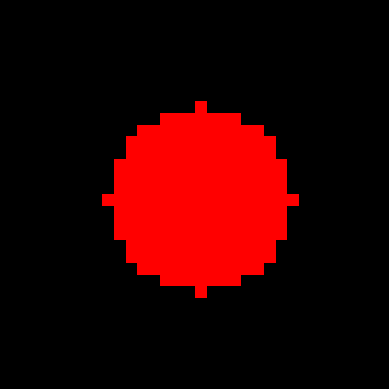

In [3]:
helper_utils.plot_image(ball_tensor)

#### 1.2.1 Visualizing a Convolutional Layer

To understand what a convolutional layer detects, you should visualize its feature maps or activation outputs. When an image is processed through this layer, it is transformed into a set of feature maps that highlight various features such as edges, textures, or shapes in the input. By visualizing these feature maps, you can see which regions of the input activate specific filters, providing insight into how the network interprets and extracts crucial information from the image.

In [4]:
out_channels=16
kernel_size=3 
stride=1
padding=1

# Define a 2D convolutional layer with specified parameters.
conv_layer = nn.Conv2d(in_channels=3, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

# Apply the convolutional layer to the input tensor.
output_conv_layer = conv_layer(ball_tensor)

# Print the shape of the tensor before and after convolution for comparison.
print(f"Input tensor shape: {ball_tensor.shape}")
print(f"Output tensor shape after convolution: {output_conv_layer.shape}")

Input tensor shape: torch.Size([3, 32, 32])
Output tensor shape after convolution: torch.Size([16, 32, 32])


Deeper network layers have larger receptive fields and smaller feature maps, balancing local details with global context for effective pattern interpretation.

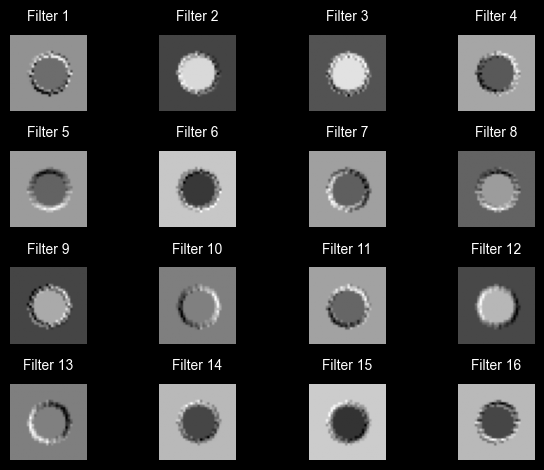

In [5]:
# Loop over each output channel (filter)
for i in range(out_channels):
    # Determine the grid size based on total number of filters
    grid_size = int(np.ceil(np.sqrt(out_channels)))
    # Add a subplot in a grid layout for each filter
    plt.subplot(grid_size, grid_size, i + 1)
    # Detach the tensor from the computation graph, convert to numpy array for visualization
    plt.imshow(output_conv_layer[i].detach().numpy(), cmap='gray')
    # Remove axis for a cleaner look
    plt.axis('off')
    # Set the title for each filter with proper formatting
    plt.title(f'Filter {i+1}', fontsize=10, pad=10)  
# Adjust layout to prevent overlap
plt.tight_layout()  
# Display the plot with all filters
plt.show()

### 1.2.2 Pooling Layer
In this section, we will explore how a pooling layer behaves on different layers of the network, focusing on its effect in reducing the spatial dimensions of feature maps.

#### **Mathematical Definition of Pooling**
Pooling is a downsampling operation that reduces the spatial dimensions of feature maps. For a 2D pooling operation with kernel size $k \times k$ and stride $s$:

**Max Pooling:**
$$y_{i,j} = \max_{m,n \in R_{i,j}} x_{m,n}$$

**Average Pooling:**
$$y_{i,j} = \frac{1}{k^2} \sum_{m,n \in R_{i,j}} x_{m,n}$$

where $R_{i,j}$ is the pooling region (receptive field) for output position $(i,j)$, defined as:
$$R_{i,j} = \{(m,n) : i \cdot s \leq m < i \cdot s + k, \quad j \cdot s \leq n < j \cdot s + k\}$$

**Output dimensions** after pooling:
$$H_{out} = \left\lfloor \frac{H_{in} - k}{s} \right\rfloor + 1$$
$$W_{out} = \left\lfloor \frac{W_{in} - k}{s} \right\rfloor + 1$$

where $H_{in}, W_{in}$ are input height and width, and $\lfloor \cdot \rfloor$ denotes the floor function.

#### **Example: 2×2 Pooling on a 4×4 Matrix**
Let's apply 2×2 pooling with stride=2 to a 4×4 input matrix.

**Input Matrix (4×4):**
$$X = \left[\begin{array}{cccc}
1 & 3 & 2 & 4 \\
5 & 6 & 7 & 8 \\
9 & 2 & 3 & 1 \\
4 & 5 & 6 & 2
\end{array}\right]$$

**Output Dimensions:**
- $H_{out} = \lfloor \frac{4 - 2}{2} \rfloor + 1 = 1 + 1 = 2$
- $W_{out} = \lfloor \frac{4 - 2}{2} \rfloor + 1 = 1 + 1 = 2$
- Output will be 2×2

**Max Pooling Computations:**

Position (0,0): Pool region = rows [0:2], cols [0:2]
$$\left[\begin{array}{cc}
1 & 3 \\
5 & 6
\end{array}\right] \rightarrow \max(1, 3, 5, 6) = 6$$

Position (0,1): Pool region = rows [0:2], cols [2:4]
$$\left[\begin{array}{cc}
2 & 4 \\
7 & 8
\end{array}\right] \rightarrow \max(2, 4, 7, 8) = 8$$

Position (1,0): Pool region = rows [2:4], cols [0:2]
$$\left[\begin{array}{cc}
9 & 2 \\
4 & 5
\end{array}\right] \rightarrow \max(9, 2, 4, 5) = 9$$

Position (1,1): Pool region = rows [2:4], cols [2:4]
$$\left[\begin{array}{cc}
3 & 1 \\
6 & 2
\end{array}\right] \rightarrow \max(3, 1, 6, 2) = 6$$

**Max Pooling Output (2×2):**
$$Y_{max} = \left[\begin{array}{cc}
6 & 8 \\
9 & 6
\end{array}\right]$$

**Average Pooling Computations:**

Position (0,0): Pool region = rows [0:2], cols [0:2]
$$\left[\begin{array}{cc}
1 & 3 \\
5 & 6
\end{array}\right] \rightarrow \text{avg}(1, 3, 5, 6) = \frac{15}{4} = 3.75$$

Position (0,1): Pool region = rows [0:2], cols [2:4]
$$\left[\begin{array}{cc}
2 & 4 \\
7 & 8
\end{array}\right] \rightarrow \text{avg}(2, 4, 7, 8) = \frac{21}{4} = 5.25$$

Position (1,0): Pool region = rows [2:4], cols [0:2]
$$\left[\begin{array}{cc}
9 & 2 \\
4 & 5
\end{array}\right] \rightarrow \text{avg}(9, 2, 4, 5) = \frac{20}{4} = 5.00$$

Position (1,1): Pool region = rows [2:4], cols [2:4]
$$\left[\begin{array}{cc}
3 & 1 \\
6 & 2
\end{array}\right] \rightarrow \text{avg}(3, 1, 6, 2) = \frac{12}{4} = 3.00$$

**Average Pooling Output (2×2):**
$$Y_{avg} = \left[\begin{array}{cc}
3.75 & 5.25 \\
5.00 & 3.00
\end{array}\right]$$

Notice how pooling reduces the spatial dimensions from 4×4 to 2×2, while preserving important features (maximum values) or computing representative values (averages) from each region.

In [6]:
# Define the parameters for the max pooling layer
pool_kernel_size = 2  # Size of the pooling window
pool_stride = 2       # Stride of the pooling window

# Create a MaxPool2d layer with specified kernel size and stride
max_pool_layer = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)

# Apply the max pooling layer to the input tensor
pooled_tensor = max_pool_layer(ball_tensor)

# Print the tensor shape before and after pooling to observe the dimensionality reduction
print(f"Shape of input tensor before pooling: {ball_tensor.shape}")
print(f"Shape of tensor after pooling: {pooled_tensor.shape}")

Shape of input tensor before pooling: torch.Size([3, 32, 32])
Shape of tensor after pooling: torch.Size([3, 16, 16])


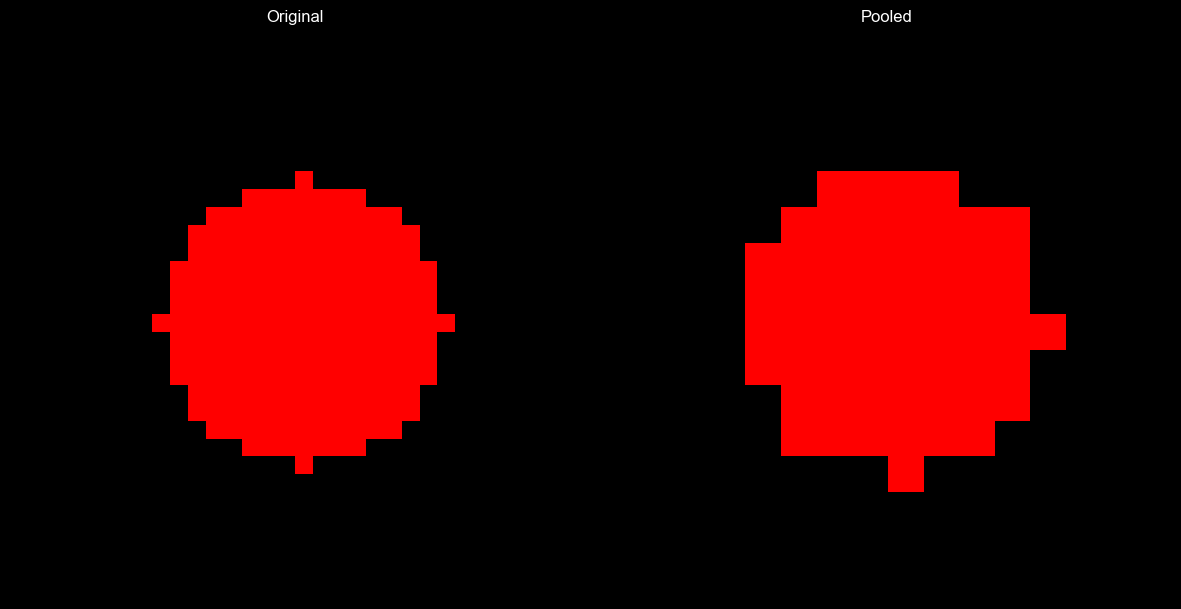

In [7]:
# Visualize the original and pooled images side by side
plt.figure(figsize=(12, 6))  # Set figure size for clarity

# Plot original image
plt.subplot(1, 2, 1)
helper_utils.plot_image(ball_tensor, title='Original', aspect='equal')

# Plot pooled image
plt.subplot(1, 2, 2)
helper_utils.plot_image(pooled_tensor, title='Pooled', aspect='equal')

# Adjust layout to prevent overlap and display the figure
plt.tight_layout()
plt.show()

### 1.3 Building and Understanding a Basic 3-Layer CNN
In this section, we will construct a simple convolutional neural network consisting of three layers. This foundational architecture provides a clear view of fundamental deep learning operations such as convolution, activation functions, and pooling.

#### **Mathematical Definition of 2D Convolution**
The 2D convolution operation is the core building block of CNNs. For an input feature map $X$ and a kernel (filter) $K$ of size $k \times k$, the convolution operation is defined as:

$$Y_{i,j} = \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} K_{m,n} \cdot X_{i+m, j+n} + b$$

where:
- $Y_{i,j}$ is the output at position $(i,j)$
- $K_{m,n}$ is the kernel weight at position $(m,n)$
- $X_{i+m, j+n}$ is the input value at position $(i+m, j+n)$
- $b$ is the bias term

**With stride $s$ and padding $p$**, the output dimensions are:
$$H_{out} = \left\lfloor \frac{H_{in} + 2p - k}{s} \right\rfloor + 1$$
$$W_{out} = \left\lfloor \frac{W_{in} + 2p - k}{s} \right\rfloor + 1$$

#### **Example: 3×3 Convolution with 2×2 Kernel**
Let's apply a 2×2 kernel to a 3×3 input matrix (stride=1, no padding, bias=0).

**Input Matrix X (3×3):**
$$X = \left[\begin{array}{ccc}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{array}\right]$$

**Kernel K (2×2):**
$$K = \left[\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right]$$

This kernel acts as an edge detector, computing the difference between diagonal elements.

**Output Dimensions:**
- $H_{out} = \lfloor \frac{3 + 2(0) - 2}{1} \rfloor + 1 = 1 + 1 = 2$
- $W_{out} = \lfloor \frac{3 + 2(0) - 2}{1} \rfloor + 1 = 1 + 1 = 2$
- Output will be 2×2

**Convolution Computations:**

Position (0,0): Apply kernel to top-left 2×2 region
$$\left[\begin{array}{cc}
1 & 2 \\
4 & 5
\end{array}\right] \odot \left[\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right] = (1 \times 1) + (2 \times 0) + (4 \times 0) + (5 \times -1) = 1 - 5 = -4$$

Position (0,1): Apply kernel to top-right 2×2 region
$$\left[\begin{array}{cc}
2 & 3 \\
5 & 6
\end{array}\right] \odot \left[\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right] = (2 \times 1) + (3 \times 0) + (5 \times 0) + (6 \times -1) = 2 - 6 = -4$$

Position (1,0): Apply kernel to bottom-left 2×2 region
$$\left[\begin{array}{cc}
4 & 5 \\
7 & 8
\end{array}\right] \odot \left[\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right] = (4 \times 1) + (5 \times 0) + (7 \times 0) + (8 \times -1) = 4 - 8 = -4$$

Position (1,1): Apply kernel to bottom-right 2×2 region
$$\left[\begin{array}{cc}
5 & 6 \\
8 & 9
\end{array}\right] \odot \left[\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right] = (5 \times 1) + (6 \times 0) + (8 \times 0) + (9 \times -1) = 5 - 9 = -4$$

**Convolution Output Y (2×2):**
$$Y = \left[\begin{array}{cc}
-4 & -4 \\
-4 & -4
\end{array}\right]$$

The uniform output of -4 indicates that the difference between the top-left and bottom-right corners is constant across all 2×2 regions in our input, which makes sense given the regular pattern in our input matrix (consecutive integers).

#### **Example with Different Kernel: Vertical Edge Detection**
Let's try a different kernel that detects vertical edges:

**Kernel K (2×2):**
$$K = \left[\begin{array}{cc}
1 & -1 \\
1 & -1
\end{array}\right]$$

**Convolution Computations:**

Position (0,0):
$$\left[\begin{array}{cc}
1 & 2 \\
4 & 5
\end{array}\right] \odot \left[\begin{array}{cc}
1 & -1 \\
1 & -1
\end{array}\right] = (1 \times 1) + (2 \times -1) + (4 \times 1) + (5 \times -1) = 1 - 2 + 4 - 5 = -2$$

Position (0,1):
$$\left[\begin{array}{cc}
2 & 3 \\
5 & 6
\end{array}\right] \odot \left[\begin{array}{cc}
1 & -1 \\
1 & -1
\end{array}\right] = (2 \times 1) + (3 \times -1) + (5 \times 1) + (6 \times -1) = 2 - 3 + 5 - 6 = -2$$

Position (1,0):
$$\left[\begin{array}{cc}
4 & 5 \\
7 & 8
\end{array}\right] \odot \left[\begin{array}{cc}
1 & -1 \\
1 & -1
\end{array}\right] = (4 \times 1) + (5 \times -1) + (7 \times 1) + (8 \times -1) = 4 - 5 + 7 - 8 = -2$$

Position (1,1):
$$\left[\begin{array}{cc}
5 & 6 \\
8 & 9
\end{array}\right] \odot \left[\begin{array}{cc}
1 & -1 \\
1 & -1
\end{array}\right] = (5 \times 1) + (6 \times -1) + (8 \times 1) + (9 \times -1) = 5 - 6 + 8 - 9 = -2$$

**Output Y (2×2):**
$$Y = \left[\begin{array}{cc}
-2 & -2 \\
-2 & -2
\end{array}\right]$$

This kernel detects the consistent horizontal gradient in our input matrix.

**For multiple channels**, if the input has $C_{in}$ channels and we want $C_{out}$ output channels:
$$Y_{c_{out}, i, j} = \sum_{c_{in}=0}^{C_{in}-1} \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} K_{c_{out}, c_{in}, m, n} \cdot X_{c_{in}, i+m, j+n} + b_{c_{out}}$$

This shows how each output channel is computed by convolving across all input channels with different kernels and summing the results.

In [8]:
class ThreeLayerCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),  # 3 input channels, 16 filters
                nn.ReLU(),  # ReLU activation adds non-linearity
                nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial dimensions by 2
            ),
            nn.Sequential(
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),  # 16 input channels, 32 filters
                nn.ReLU(),  # ReLU activation
                nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling reduces size by half
            ),
            nn.Sequential(
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # 32 input channels, 64 filters
                nn.ReLU(),  # Activation
                nn.MaxPool2d(kernel_size=2, stride=2)  # Further size reduction
            )
        ])
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### 1.4 Hook Function

In this section, we introduce the concept of hook functions in PyTorch. Hooks are functions that you can register to a layer in a neural network to extract, modify, or monitor its outputs and internal states during the forward and backward passes. They are powerful tools for visualizing what the network learns and for debugging. Here, we focus on forward hooks, which allow us to capture intermediate outputs at desired layers of the network, making it possible to visualize feature maps and understand how data flows through the model.

In [9]:
# Dictionary to store the captured feature maps
activations = {}

# Hook function to intercept and store intermediate activations
# 'name' is used as the key in the 'activations' dictionary
# This function creates a closure capturing 'name' for later use

def grab(name):
    def hook(model, input, output):
        # Detach the output tensor from the computation graph
        # This prevents gradients from accumulating and saves memory
        # Store this tensor in the 'activations' dictionary with 'name' as the key
        activations[name] = output.detach()
    return hook


In [10]:
model = ThreeLayerCNN()

#### 1.4.1 Registering Forward Hooks

In this step, you'll register forward hooks on the layers of your neural network that you're interested in examining. Forward hooks allow you to capture the output of a layer during the forward pass, which is essential for visualizing feature maps or collecting intermediate activations.

To do this, you call the `register_forward_hook()` method on a specific layer, passing a hook function that will be executed every time the layer performs a forward pass. This hook function receives the layer, its input, and its output, enabling you to save or analyze the output for visualization or debugging purposes.

Make sure to register these hooks **before running your data through the model** to capture the desired intermediate representations.

In [11]:
# Register forward hooks on specific layers to capture activations during a forward pass
# This helps us visualize what features each layer detects
model.layers[0].register_forward_hook(grab('layer1'))  # Hook for layer1
model.layers[1].register_forward_hook(grab('layer2'))  # Hook for layer2
model.layers[2].register_forward_hook(grab('layer3'))  # Hook for layer3

In [12]:
# Passing the ball tensor to the network
output = model(ball_tensor.unsqueeze(0))
print(output.shape)

torch.Size([1, 64, 4, 4])


In [13]:
# Printing the shapes after each layer
for layer, output_tensor in activations.items():
    print(f"Output shape after {layer}: {output_tensor.shape}")

Output shape after layer1: torch.Size([1, 16, 16, 16])
Output shape after layer2: torch.Size([1, 32, 8, 8])
Output shape after layer3: torch.Size([1, 64, 4, 4])


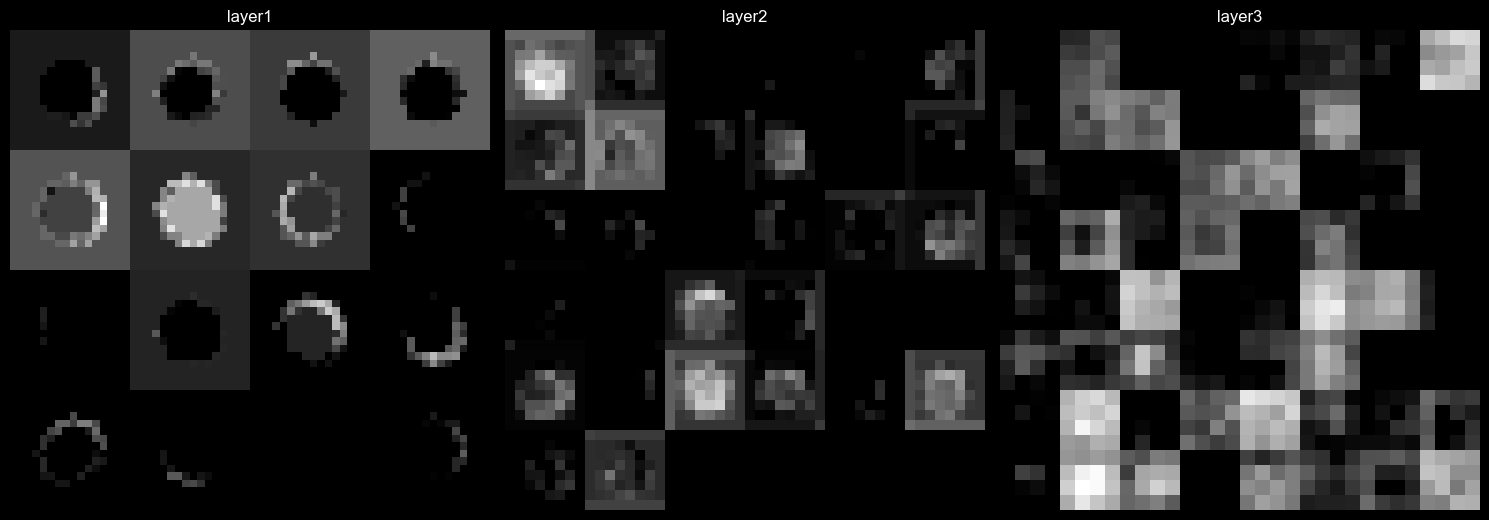

In [14]:
helper_utils.visualize_all_layers_grids(activations)

## 2 - Receptive Field in Convolutional Neural Networks
### What is the *Receptive Field*?
In a convolutional neural network (CNN), the **receptive field** of a particular neuron (unit) in a feature map is the specific region of the input image that influences the value of that neuron. It tells us how much "context" (how large an area) from the input a unit at a certain layer can "see" or is affected by.
- **Small receptive field:** The unit "sees" a small part of the input.
- **Large receptive field:** The unit "sees" a larger part of the input and so can incorporate more global image information.
### Why is the receptive field important?
- It helps us understand **how much of the input image** each feature at a given layer is using.
- Larger receptive fields allow the network to capture more complex, global patterns.
- If the receptive field is too small, the network may miss important global information.
### How is the receptive field computed?
We can **recursively calculate** the receptive field as we stack layers in a CNN:
#### For a single convolution or pooling layer:
- The **receptive field increases** with the kernel size — each neuron looks at a window of the previous layer.
- If a layer uses *stride* or *dilation*, these also affect how much the receptive field grows.

#### **Key Terms:**
- **Kernel:** The filter window (e.g., 3×3) that slides over the input to extract features.
- **Stride:** The step size by which the kernel moves across the input (stride=2 means skip every other position).
- **Dilation:** The spacing between kernel elements (dilation=2 means insert gaps between kernel values).

#### **Recursive Calculation Rule:**
Suppose you have a layer with:
- kernel size $ k $
- stride $ s $
- (optional) dilation $ d $ (usually 1 if not specified)
- previous layer's receptive field $ r_{prev} $
- previous layer's jump/stride $ j_{prev} $

Then:
$$
r_{new} = r_{prev} + (k - 1) \times j_{prev} \times d
$$
$$
j_{new} = j_{prev} \times s
$$
- **Receptive field** increases each time by the size and arrangement of the kernel.
- **Jump** is the effective stride between two neighboring units in the current feature map, measured in the original input image.

#### **Example Calculation**
Imagine an input image with size 224x224. 
Suppose our network looks like this:
| Layer type        | Kernel | Stride | Padding |
|-------------------|--------|--------|---------|
| Input             | N/A    | N/A    | N/A     |
| Conv2d            | 3      | 1      | 1       |
| MaxPool2d         | 2      | 2      | 0       |
- Start with \( r = 1 \), \( j = 1 \) (every input pixel "sees" itself).
- After **conv layer** (\( k=3, s=1 \)):  
  \( r = 1 + (3-1)*1 = 3 \), \( j = 1*1 = 1 \)
- After **pool layer** (\( k=2, s=2 \)):  
  \( r = 3 + (2-1)*1 = 4 \), \( j = 1*2 = 2 \)

So after these two layers, each neuron in the feature map "sees" a 4x4 patch of the original input image, and neighboring neurons correspond to positions 2 pixels apart in the input.
### **In summary:**
- The **receptive field** measures how much of the input contributes to each feature at each layer.
- It **grows gradually** as you stack more layers, especially if you use larger kernels, more pooling, or bigger strides.
- Understanding and calculating the receptive field lets you design neural networks that can see the right amount of context in your images.
Let's plot it!

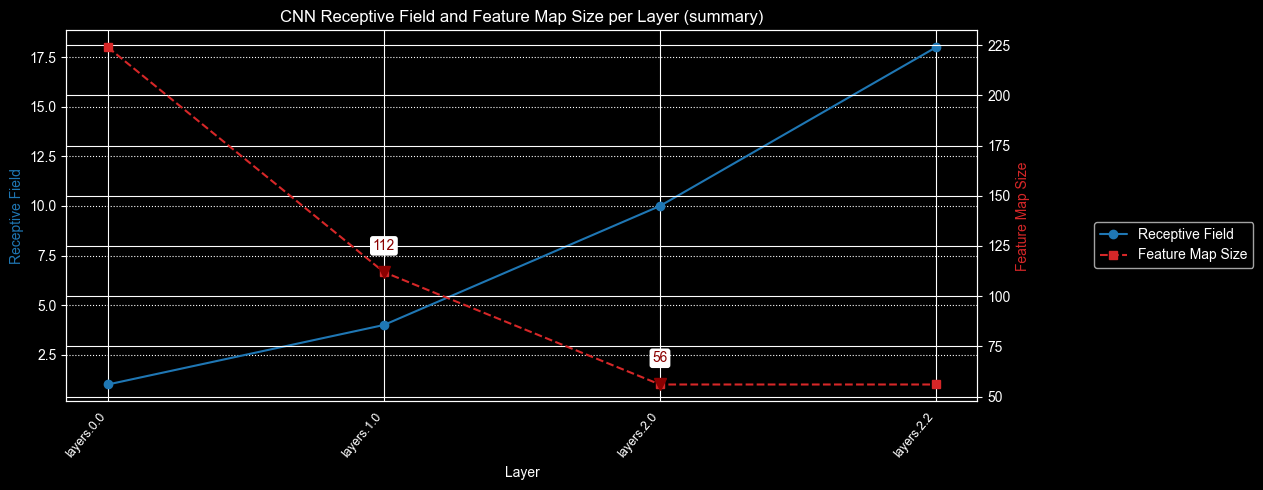

In [15]:
rfinfo = helper_utils.calculate_receptive_field(model, input_size=224)
helper_utils.plot_receptive_field_summary(rfinfo)

## 3 - A Practical Example with ResNet

This section demonstrates how ResNet processes an image internally. We'll explore how an image is transformed as it passes through various layers of the network and examine the Receptive Field graph to understand the context each neuron considers. This hands-on example provides insight into ResNet's architecture and operation, highlighting the flow of information from input to output.

In [16]:
# Load pre-trained ResNet50 from local cache
import os
torch.hub.set_dir(os.path.join(os.getcwd(), 'pretrained_model'))
model = tv_models.resnet50(weights=tv_models.ResNet50_Weights.IMAGENET1K_V2)
model.eval()
print("")

In [17]:
help(tv_models.resnet50)

Help on function resnet50 in module torchvision.models.resnet:

resnet50(
    *,
    weights: Optional[torchvision.models.resnet.ResNet50_Weights] = None,
    progress: bool = True,
    **kwargs: Any
) -> torchvision.models.resnet.ResNet
    ResNet-50 from `Deep Residual Learning for Image Recognition <https://arxiv.org/abs/1512.03385>`__.

    .. note::
       The bottleneck of TorchVision places the stride for downsampling to the second 3x3
       convolution while the original paper places it to the first 1x1 convolution.
       This variant improves the accuracy and is known as `ResNet V1.5
       <https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch>`_.

    Args:
        weights (:class:`~torchvision.models.ResNet50_Weights`, optional): The
            pretrained weights to use. See
            :class:`~torchvision.models.ResNet50_Weights` below for
            more details, and possible values. By default, no pre-trained
            weights are used.
  

### 3.1 Plotting the Receptive Field Map

This section visualizes the receptive field of different neurons across the network layers, demonstrating how much of the input image each neuron can 'see'. Plotting this map helps in understanding the spatial extent of the features captured by the model at various depths.

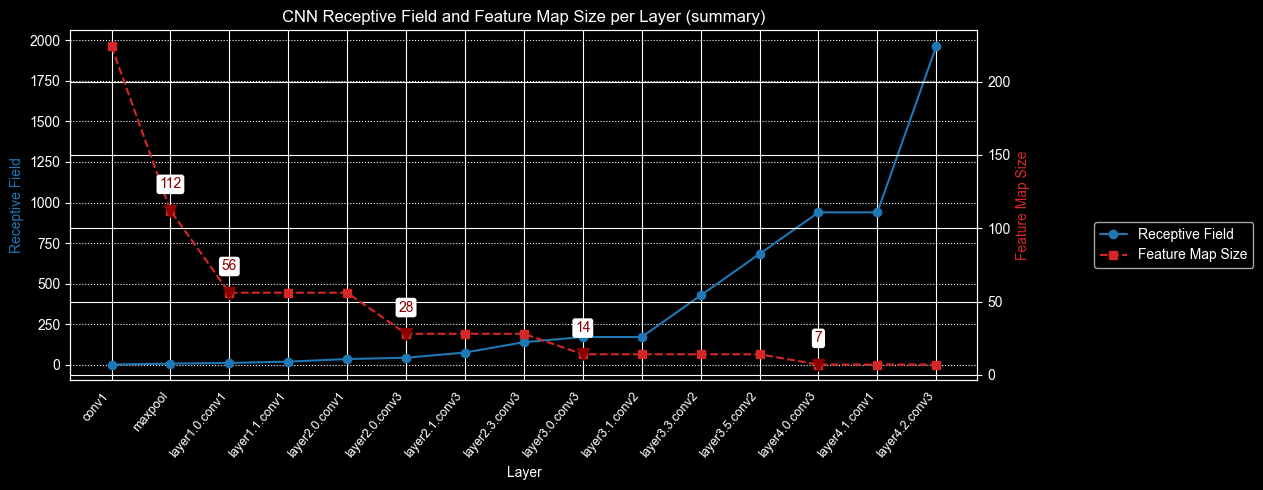

In [18]:
rfinfo = helper_utils.calculate_receptive_field(model, input_size=224)
helper_utils.plot_receptive_field_summary(rfinfo)

### 3.2 Analyzing Selected Layers of ResNet

In this section, you will examine how an image is progressively transformed as it passes through the layers of the ResNet model. We'll focus on understanding how the features evolve from the initial input up to the final prediction. Given that ResNet consists of many layers, we will select a few representative ones for detailed analysis.

#### 3.2.1 Applying Forward Hooks to ResNet Layers

In this section, you will apply forward hooks to specific layers within the ResNet architecture. 

In [19]:
# Reset activations dictionary
activations = {}
# To register a forward hook, you need to call the following method on each layer you want to register
model.conv1.register_forward_hook(grab('conv1'))           # First layer
model.layer1[0].conv1.register_forward_hook(grab('layer1'))  # Early block
model.layer2[0].conv1.register_forward_hook(grab('layer2'))  # Middle block
model.layer3[0].conv1.register_forward_hook(grab('layer3'))  # Later block
model.layer4[0].conv1.register_forward_hook(grab('layer4'))  # Deep block

#### 3.2.2 Preprocessing Pipeline

Before feeding images into ResNet, it is essential to preprocess them to match the training conditions. Typically, this involves resizing, cropping, normalization, and tensor conversion. The standard steps are:

1. **Resize:** Adjust the image so that the shorter side is 256 pixels.
2. **Center Crop:** Crop a 224x224 pixel region from the center of the resized image.
3. **To Tensor:** Convert the PIL image into a PyTorch tensor.
4. **Normalize:** Adjust the pixel values using mean and standard deviation values that match the ImageNet dataset (mean: [0.485, 0.456, 0.406], std: [0.229, 0.224, 0.225]) to ensure consistency with the model's training conditions.

This pipeline ensures that the input images are properly scaled and normalized, which is crucial for the model to perform accurately.

In [20]:
# Load and preprocess an image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load a sample image (let's say we have a cat image)
image = Image.open('images/cat.jpg')
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

(np.float64(-0.5), np.float64(639.5), np.float64(425.5), np.float64(-0.5))

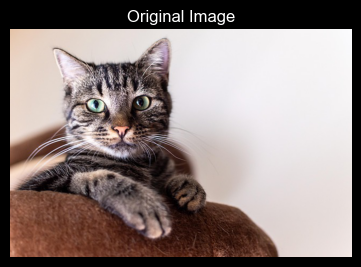

In [21]:
# Forward pass through the model
with torch.no_grad():
    output = model(input_tensor)

# Visualize the input image and feature maps
plt.figure(figsize=(15, 10))

# Display original image
plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

### 3.3 Exploring Feature Maps and Receptive Fields in ResNet

In this part, you will look inside ResNet by seeing its feature maps and understanding how neurons respond in different layers. Looking at these helps you understand how ResNet processes and makes sense of complicated pictures. It shows what kinds of features the network detects at each level. By studying feature maps and receptive fields, you can learn how ResNet builds up a detailed understanding of visual information in steps.

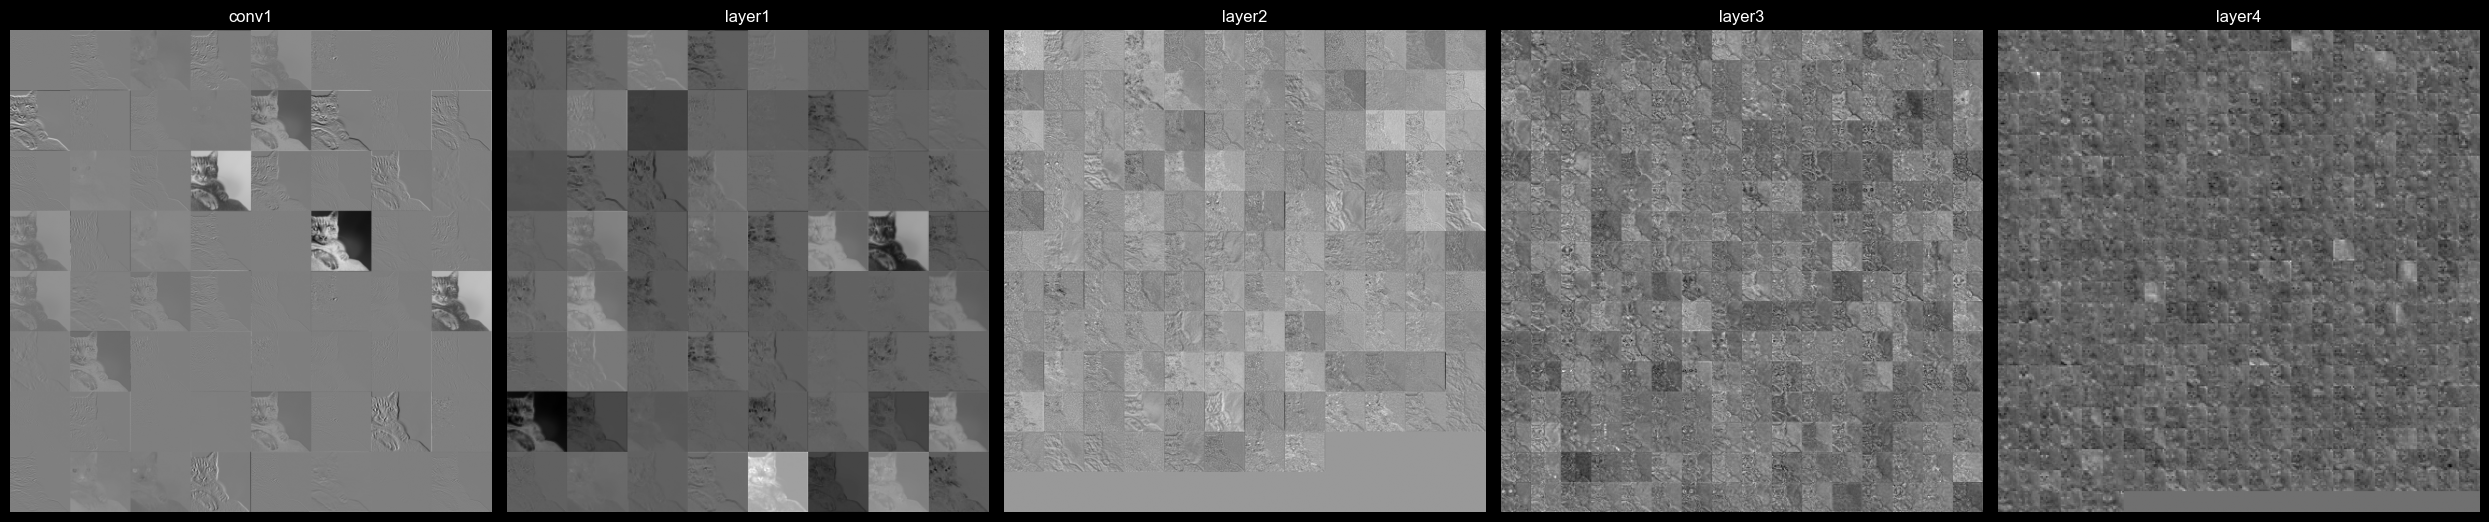

In [22]:
helper_utils.visualize_all_layers_grids(activations)

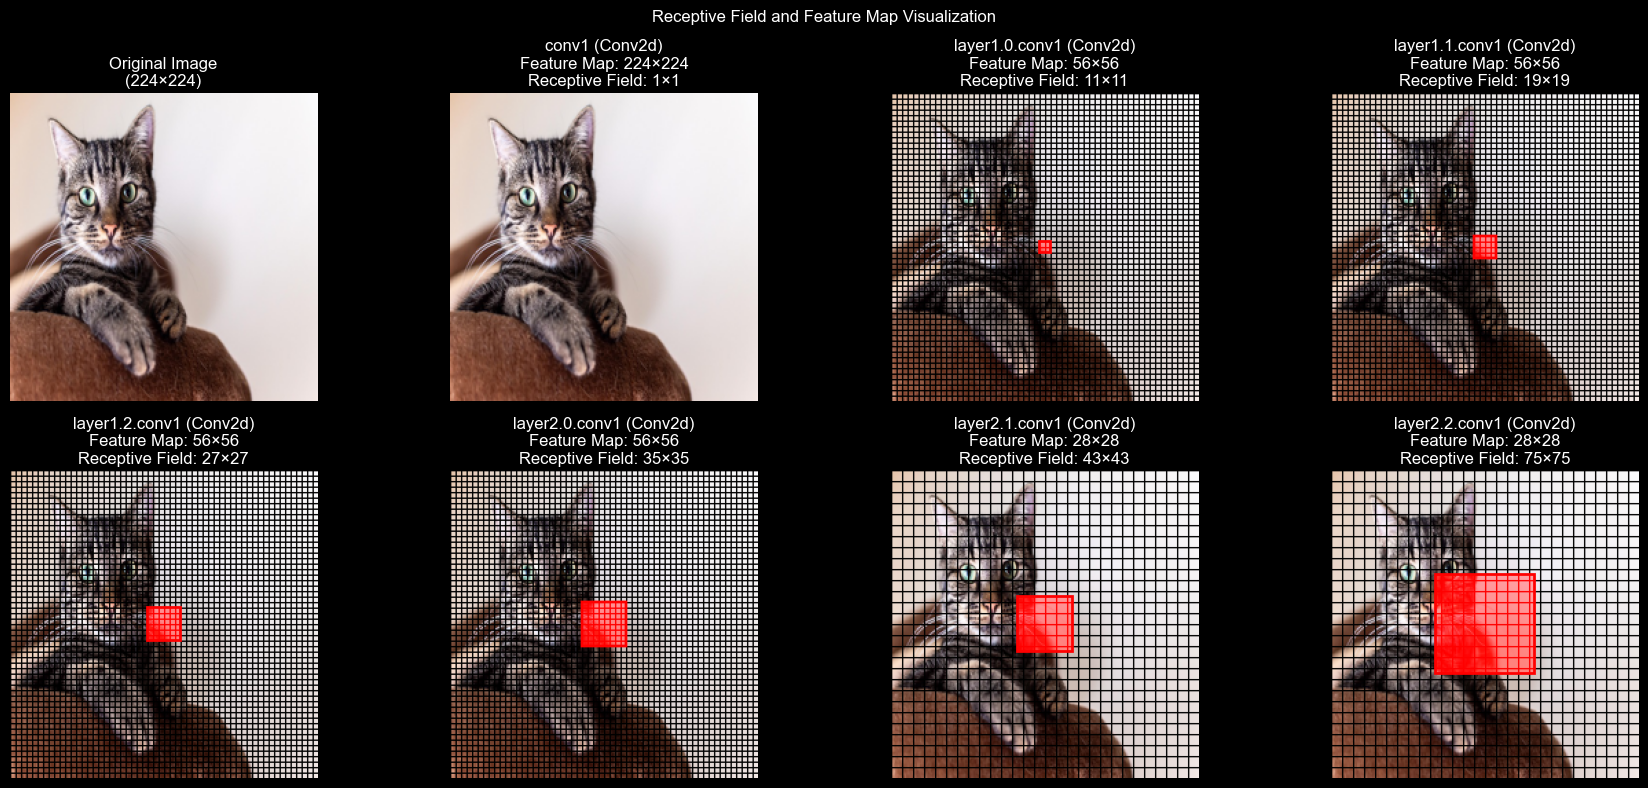

In [23]:
helper_utils.plot_rfinfo_over_image(rfinfo, 'images/cat.jpg', input_size=224)

### 3.4 Interactive Visualization of Image Transformations in ResNet

This widget enables you to see how an input image is transformed at each layer of the ResNet model. You can navigate through the layers to observe feature extraction and representation refinement, culminating in the final classification.

In [24]:
helper_utils.plot_widget(model)

## 4 - Conclusion

In this notebook, you explored the inner workings of CNNs using various visualization techniques. You learned how to examine what each layer detects, discovering that early layers focus on simple features like edges and textures, while deeper layers recognize complex objects and patterns.

Understanding the receptive field helped you grasp how much of the input image each neuron can 'see' at different stages, revealing the hierarchical process of feature extraction.

Analyzing advanced models like ResNet showed how deep neural networks build a comprehensive understanding of visual data layer by layer.

These visualization tools are crucial for debugging, interpreting, and improving neural networks. They assist you in developing more accurate and explainable models that better understand the visual world.